#### Geographical and Time

In [1]:
import sys
print(sys.version)

3.8.15 | packaged by conda-forge | (default, Nov 22 2022, 08:46:39) 
[GCC 10.4.0]


In [2]:
spark.version

'3.1.3'

In [3]:
import pandas as pd
import numpy as np
pd.set_option('display.max_colwidth', None)
pd.reset_option('display.max_rows')
from itertools import compress 
from pyspark.sql.functions import *
from pyspark.sql.types import *
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings(action='ignore')

In [4]:
from pyspark.sql import SparkSession
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql import Row
from pyspark.sql.functions import col

In [5]:
spark.conf.set("spark.sql.repl.eagerEval.enabled",True)

In [6]:
%%time
twitter = spark.read.parquet('gs://chen26-bdp/original_data')

CPU times: user 6.35 ms, sys: 3.72 ms, total: 10.1 ms
Wall time: 8.38 s


23/03/05 02:19:11 WARN org.apache.spark.sql.catalyst.util.package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [7]:
keywords = ['college', 'high', 'university', 'students'
            , 'public', 'private', 'secondary', 'primary', 'education', 'undergraduate','graduate']
#filter out rows that do not contain words in keywords
twitter = twitter.withColumn('lower', lower(col('text')))
filter_twitter = twitter.filter(col('lower').rlike('|'.join(keywords)))

twitter_eng = filter_twitter.filter(col('lang') == 'en')
from pyspark.sql import functions as F
from pyspark.sql import types as t
from pyspark.sql.types import ArrayType, IntegerType, BooleanType

eng_ord=F.udf(lambda x: [ord(a) for a in x],t.ArrayType(IntegerType()))

def english_filter(x):
    for index in range(len(x)):
        if x[index] > 128:
            return False
        else:
            return True

filter_udf = F.udf(english_filter, BooleanType())
tweets = twitter_eng.filter(filter_udf(eng_ord('text')) == True)

In [8]:
time = tweets.select('created_at')

In [9]:
time.show(10, truncate = False)

+------------------------------+
|created_at                    |
+------------------------------+
|Sun Dec 18 00:53:14 +0000 2022|
|Sun Dec 18 00:53:15 +0000 2022|
|Sun Dec 18 00:53:16 +0000 2022|
|Sun Dec 18 00:53:17 +0000 2022|
|Sun Dec 18 00:53:18 +0000 2022|
|Sun Dec 18 00:53:18 +0000 2022|
|Sun Dec 18 00:53:19 +0000 2022|
|Sun Dec 18 00:53:19 +0000 2022|
|Sun Dec 18 00:53:22 +0000 2022|
|Sun Dec 18 00:53:22 +0000 2022|
+------------------------------+
only showing top 10 rows



In [10]:
from pyspark.sql.functions import from_unixtime, date_format
spark.sql("set spark.sql.legacy.timeParserPolicy=LEGACY")

time_new = time.withColumn("timestamp_unix", from_unixtime(unix_timestamp("created_at", "EEE MMM dd HH:mm:ss Z yyyy")))
time_new = time_new.withColumn("date", date_format("timestamp_unix", "yyyy-MM-dd"))

In [11]:
# Show the updated DataFrame
time_new.show()

+--------------------+-------------------+----------+
|          created_at|     timestamp_unix|      date|
+--------------------+-------------------+----------+
|Sun Dec 18 00:53:...|2022-12-18 00:53:14|2022-12-18|
|Sun Dec 18 00:53:...|2022-12-18 00:53:15|2022-12-18|
|Sun Dec 18 00:53:...|2022-12-18 00:53:16|2022-12-18|
|Sun Dec 18 00:53:...|2022-12-18 00:53:17|2022-12-18|
|Sun Dec 18 00:53:...|2022-12-18 00:53:18|2022-12-18|
|Sun Dec 18 00:53:...|2022-12-18 00:53:18|2022-12-18|
|Sun Dec 18 00:53:...|2022-12-18 00:53:19|2022-12-18|
|Sun Dec 18 00:53:...|2022-12-18 00:53:19|2022-12-18|
|Sun Dec 18 00:53:...|2022-12-18 00:53:22|2022-12-18|
|Sun Dec 18 00:53:...|2022-12-18 00:53:22|2022-12-18|
|Sun Dec 18 00:53:...|2022-12-18 00:53:23|2022-12-18|
|Sun Dec 18 00:53:...|2022-12-18 00:53:27|2022-12-18|
|Sun Dec 18 00:53:...|2022-12-18 00:53:28|2022-12-18|
|Sun Dec 18 00:53:...|2022-12-18 00:53:28|2022-12-18|
|Sun Dec 18 00:53:...|2022-12-18 00:53:29|2022-12-18|
|Sun Dec 18 00:53:...|2022-1

In [12]:
tweets_day = tweets.select('id', 'created_at')
tweets_day = tweets_day.withColumn("timestamp_unix", from_unixtime(unix_timestamp("created_at", "EEE MMM dd HH:mm:ss Z yyyy")))
tweets_day = tweets_day.withColumn("date", date_format("timestamp_unix", "yyyy-MM-dd"))
tweets_by_day = tweets_day.drop('created_at', 'timestamp_unix')

In [13]:
# Show the updated DataFrame
tweets_by_day.show()

+-------------------+----------+
|                 id|      date|
+-------------------+----------+
|1604278583291256832|2022-12-18|
|1604278587183415297|2022-12-18|
|1604278590614315008|2022-12-18|
|1604278595215671296|2022-12-18|
|1604278597019115520|2022-12-18|
|1604278598155702273|2022-12-18|
|1604278600655507456|2022-12-18|
|1604278604354834433|2022-12-18|
|1604278614618279936|2022-12-18|
|1604278614748528642|2022-12-18|
|1604278620993757186|2022-12-18|
|1604278633853583362|2022-12-18|
|1604278640241278977|2022-12-18|
|1604278641076092931|2022-12-18|
|1604278643693424643|2022-12-18|
|1604278645501181952|2022-12-18|
|1604278651373199361|2022-12-18|
|1604278654892183553|2022-12-18|
|1604278659983937536|2022-12-18|
|1604278661267574785|2022-12-18|
+-------------------+----------+
only showing top 20 rows



In [14]:
total_by_day = tweets_by_day.groupby('date').agg(count('*').alias('daily_tweets'))
day_total = total_by_day.orderBy('date', ascending = True)
day_total.show()

+----------+------------+
|      date|daily_tweets|
+----------+------------+
|2022-04-05|      109939|
|2022-04-06|      141312|
|2022-04-07|      141789|
|2022-04-08|      137075|
|2022-04-09|      109139|
|2022-04-10|       98880|
|2022-04-11|      142839|
|2022-04-12|      137345|
|2022-04-13|      138168|
|2022-04-14|      118257|
|2022-04-15|      106518|
|2022-04-16|      100385|
|2022-04-17|       84230|
|2022-04-18|      115006|
|2022-04-19|      135267|
|2022-04-20|      126609|
|2022-04-21|      124602|
|2022-04-22|      121740|
|2022-04-23|       97615|
|2022-04-24|      101238|
+----------+------------+
only showing top 20 rows



In [16]:
%%time
day_total.write.format("parquet").\
mode('overwrite').\
save('gs://chen26-bdp/day_tweets')

CPU times: user 892 ms, sys: 213 ms, total: 1.1 s
Wall time: 6min 23s


In [15]:
day = day_total.toPandas()

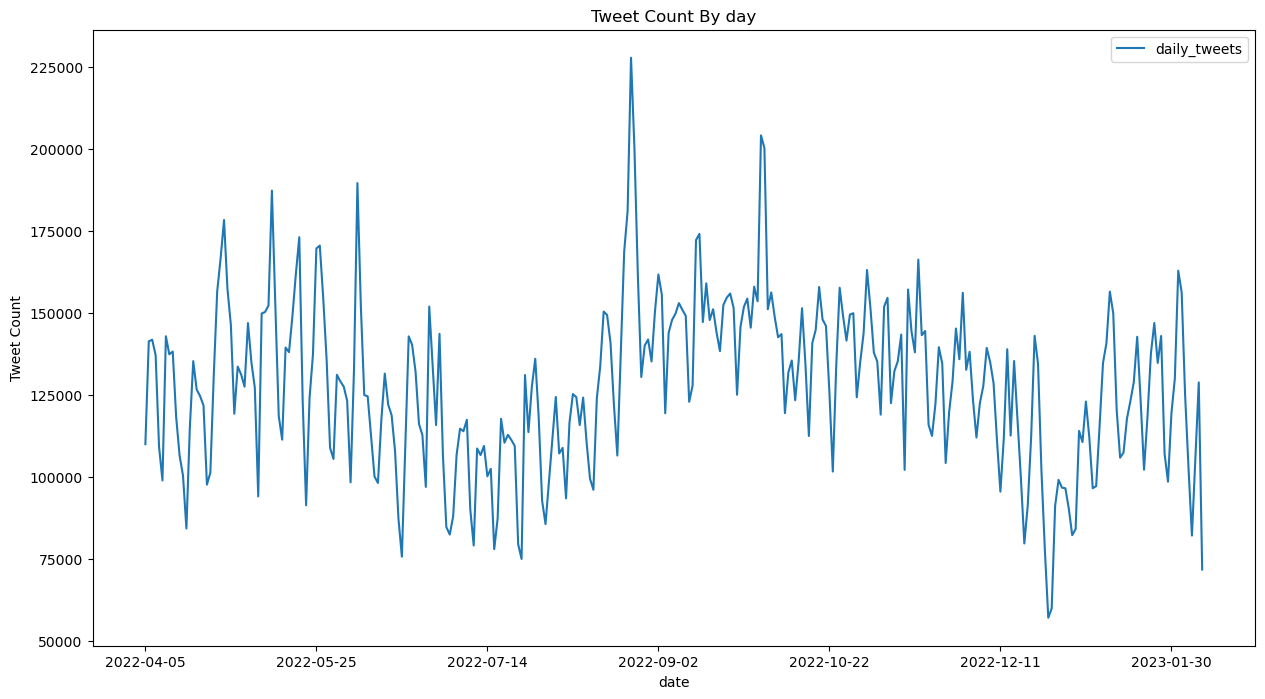

In [17]:
day.plot(kind="line",x= 'date', y="daily_tweets", figsize=(15, 8))
plt.ylabel("Tweet Count")
plt.title('Tweet Count By day')
plt.show()

In [18]:
day

,date,daily_tweets
0,2022-04-05,109939
1,2022-04-06,141312
2,2022-04-07,141789
3,2022-04-08,137075
4,2022-04-09,109139
...,...,...
305,2023-02-04,102690
306,2023-02-05,82069
307,2023-02-06,105679
308,2023-02-07,128770


In [19]:
month_total = day_total.withColumn('month', month(col('date')))

In [ ]:
month_total.show()

+----------+------------+-----+
|      date|daily_tweets|month|
+----------+------------+-----+
|2022-04-05|      109939|    4|
|2022-04-06|      141312|    4|
|2022-04-07|      141789|    4|
|2022-04-08|      137075|    4|
|2022-04-09|      109139|    4|
|2022-04-10|       98880|    4|
|2022-04-11|      142839|    4|
|2022-04-12|      137345|    4|
|2022-04-13|      138168|    4|
|2022-04-14|      118257|    4|
|2022-04-15|      106518|    4|
|2022-04-16|      100385|    4|
|2022-04-17|       84230|    4|
|2022-04-18|      115006|    4|
|2022-04-19|      135267|    4|
|2022-04-20|      126609|    4|
|2022-04-21|      124602|    4|
|2022-04-22|      121740|    4|
|2022-04-23|       97615|    4|
|2022-04-24|      101238|    4|
+----------+------------+-----+
only showing top 20 rows



In [ ]:
%%time
month_total.write.format("parquet").\
mode('overwrite').\
save('gs://chen26-bdp/month_tweets')

In [7]:
month_total = spark.read.parquet('gs://chen26-bdp/month_tweets')

In [9]:
month_total_t = month_total.groupby('month').agg(sum('daily_tweets').alias('monthly_tweets'))

In [10]:
month = month_total_t.toPandas()

In [15]:
month = month.sort_values(by = 'month')

In [16]:
month

,month,monthly_tweets
1,1,3722912
9,2,935033
5,4,3323905
3,5,4248605
2,6,3667682
6,7,3196325
10,8,4106759
4,9,4460274
7,10,4448331
8,11,4099704


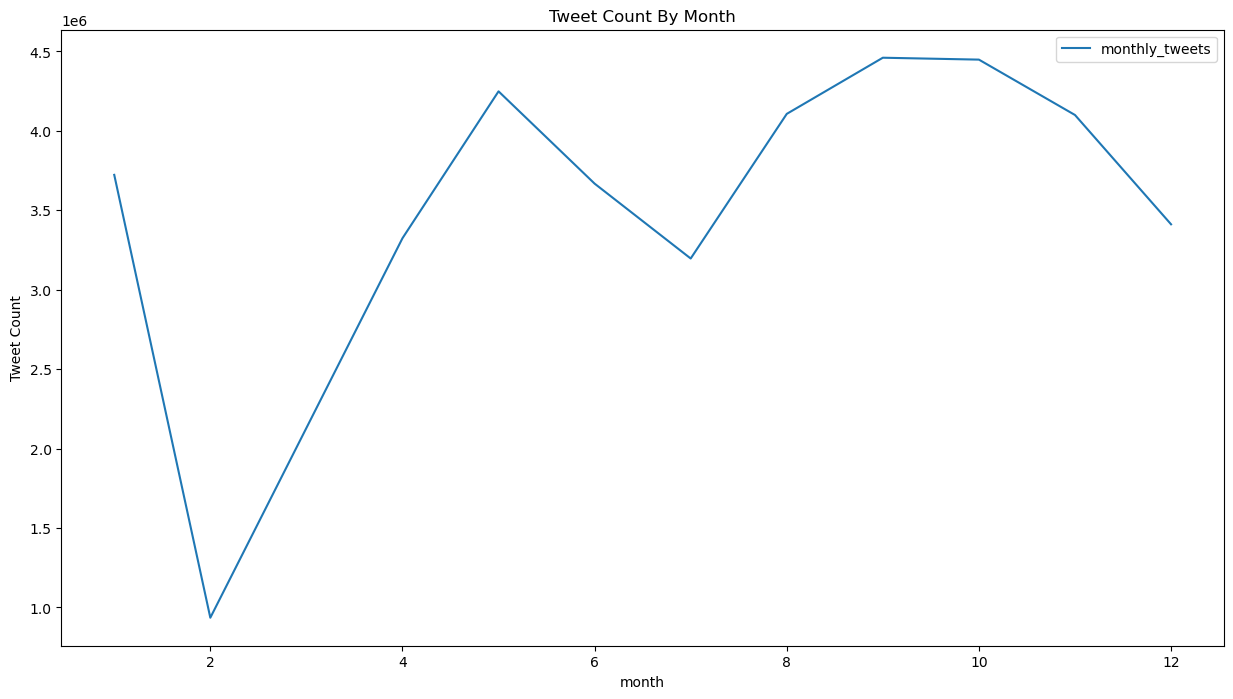

In [17]:
month.plot(kind="line",x= 'month', y="monthly_tweets", figsize=(15, 8))
plt.ylabel("Tweet Count")
plt.title('Tweet Count By Month')
plt.show()

In [29]:
spark.sql("set spark.sql.legacy.timeParserPolicy=LEGACY")
tweets_week = tweets.select('id', 'created_at')
tweets_week = tweets_week.withColumn("timestamp_unix", from_unixtime(unix_timestamp("created_at", "EEE MMM dd HH:mm:ss Z yyyy")))
tweets_week = tweets_week.withColumn('day_of_week', date_format(to_date('created_at', 'EEE MMM dd HH:mm:ss Z yyyy'), 'EEEE'))
#tweets_by_day = tweets_day.drop('created_at', 'timestamp_unix')

In [31]:
tweets_week = tweets_week.drop('timestamp_unix')

In [32]:
day_of_week = tweets_week.groupby('day_of_week').agg(count('id'))

In [ ]:
dw = day_of_week.toPandas()

In [35]:
dw.sort_values(by = 'day_of_week')

,day_of_week,count(id)
2,Friday,5861154
5,Monday,5584926
4,Saturday,5162074
6,Sunday,4629016
3,Thursday,6187074
1,Tuesday,6037232
0,Wednesday,6159644


In [37]:
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
count = [5584926, 6037232, 6159644, 6187074, 5861154, 5162074, 4629016]

tweet_week = pd.DataFrame({'Days': days, 'tweet_count': count})

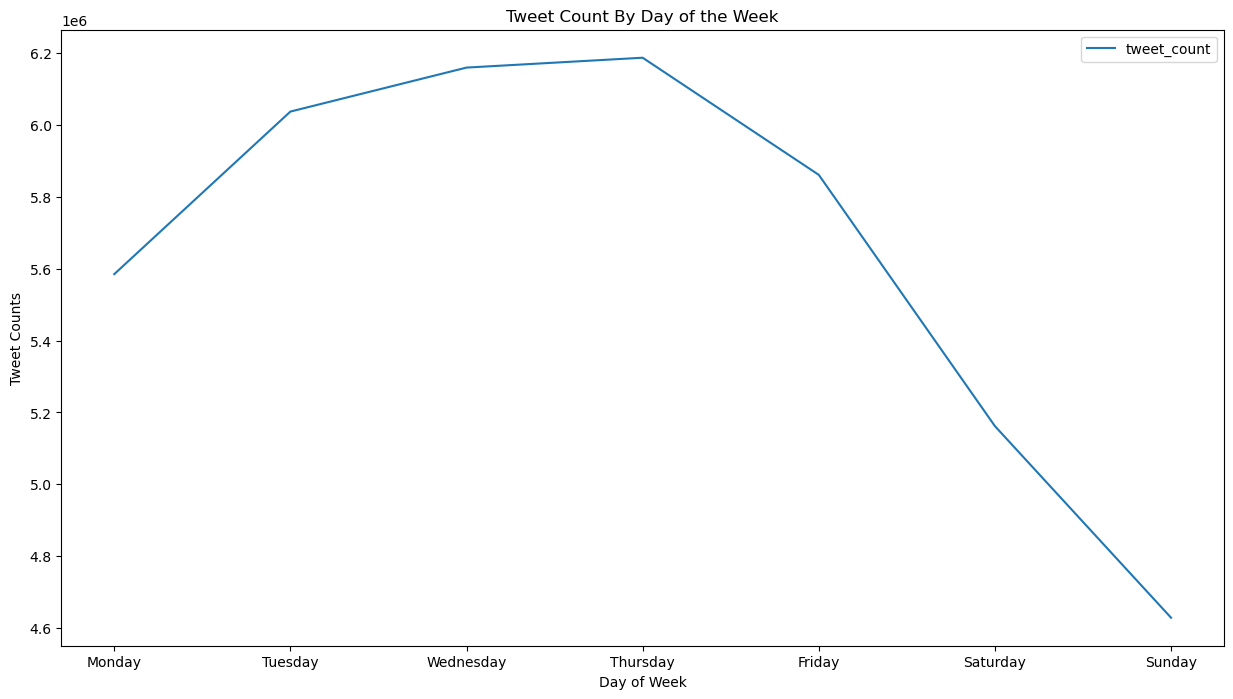

In [39]:
tweet_week.plot(kind="line",x= 'Days', y="tweet_count", figsize=(15, 8))
plt.ylabel("Tweet Counts")
plt.xlabel('Day of Week')
plt.title('Tweet Count By Day of the Week')
plt.show()

##### Geographic

In [ ]:
# tweets location

In [40]:
tweets_loc = tweets.select('id', tweets.place.country.alias('tweet_country'), tweets.place.full_name.alias('tweet_location'))

In [42]:
tweet_country = tweets_loc.select('id', 'tweet_country')

In [51]:
country = tweet_country.filter(col('tweet_country').isNotNull())

In [59]:
t_by_country = country.groupby(col('tweet_country')).agg(count('*').alias('num_tweets'))

In [61]:
top50_country = t_by_country.orderBy(col('num_tweets').desc()).limit(50)

In [63]:
top50_country_df = top50_country.toPandas()

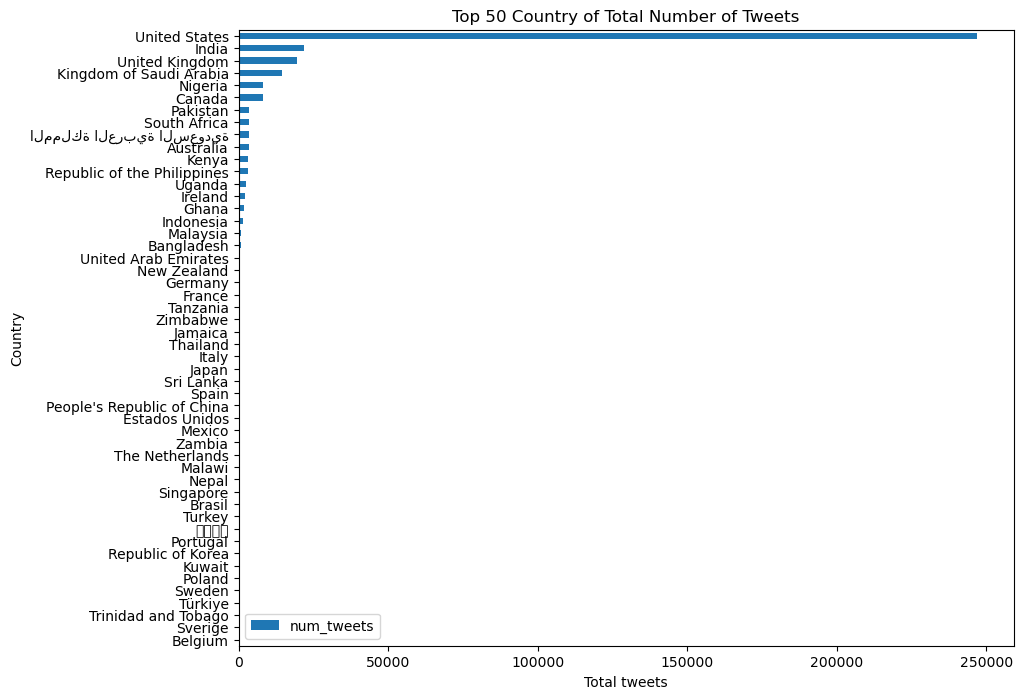

In [72]:
ax = top50_country_df.plot(x ='tweet_country',y='num_tweets', kind='barh', figsize = (10, 8))

ax.set_ylabel('Country')
ax.set_xlabel('Total tweets')
ax.set_title('Top 50 Country of Total Number of Tweets')
ax.invert_yaxis()

# show the plot
plt.show()

In [10]:
tweet_location = tweets_loc.select('id', 'tweet_location')

In [11]:
location = tweet_location.filter(col('tweet_location').isNotNull())

In [16]:
location_c = location.withColumn("loc", split(location.tweet_location, ", ").getItem(0))

In [17]:
location_c

id,tweet_location,loc
1555124473338253315,"Punjab, Pakistan",Punjab
1555124856861360128,"Bhubaneshwar, India",Bhubaneshwar
1555125171669061632,India,India
1555125396970115072,"Greengairs, Scotland",Greengairs
1530714698655596545,Mount Vernon Pres...,Mount Vernon Pres...
1530714877664403457,"Marshfield, MA",Marshfield
1530715122515296256,"Little Falls, NJ",Little Falls
1530715510123466752,"Sarasota, FL",Sarasota
1530715614649647104,"Georgia, USA",Georgia
1530716000383025159,"Virginia Beach, VA",Virginia Beach


In [19]:
t_by_location = location_c.groupby(col('loc')).agg(count('*').alias('num_tweets'))

In [20]:
top50_loc = t_by_location.orderBy(col('num_tweets').desc()).limit(50)

In [22]:
top50_loc_df = top50_loc.toPandas()

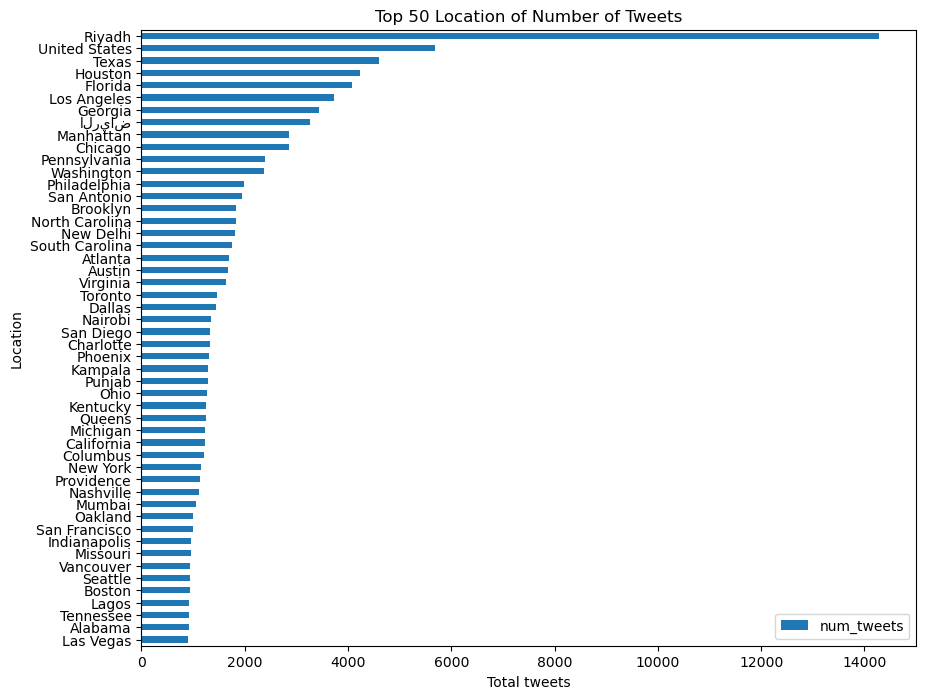

In [24]:
ax = top50_loc_df.plot(x ='loc',y='num_tweets', kind='barh', figsize = (10, 8))

ax.set_ylabel('Location')
ax.set_xlabel('Total tweets')
ax.set_title('Top 50 Location of Number of Tweets')
ax.invert_yaxis()

# show the plot
plt.show()

In [25]:
# remove locations with only country
filt_location = location.filter(col("tweet_location").like("%,%"))

In [27]:
location_f = filt_location.withColumn("loc", split(location.tweet_location, ", ").getItem(0))

In [29]:
location_f

id,tweet_location,loc
1555124473338253315,"Punjab, Pakistan",Punjab
1555124856861360128,"Bhubaneshwar, India",Bhubaneshwar
1555125396970115072,"Greengairs, Scotland",Greengairs
1530714877664403457,"Marshfield, MA",Marshfield
1530715122515296256,"Little Falls, NJ",Little Falls
1530715510123466752,"Sarasota, FL",Sarasota
1530715614649647104,"Georgia, USA",Georgia
1530716000383025159,"Virginia Beach, VA",Virginia Beach
1533456562458464261,"Philadelphia, PA",Philadelphia
1533456594264104961,"North Carolina, USA",North Carolina


In [30]:
t_by_location_f = location_f.groupby(col('loc')).agg(count('*').alias('num_tweets'))

In [31]:
top50_loc_f = t_by_location_f.orderBy(col('num_tweets').desc()).limit(50)

In [32]:
top50_loc_f_df = top50_loc_f.toPandas()

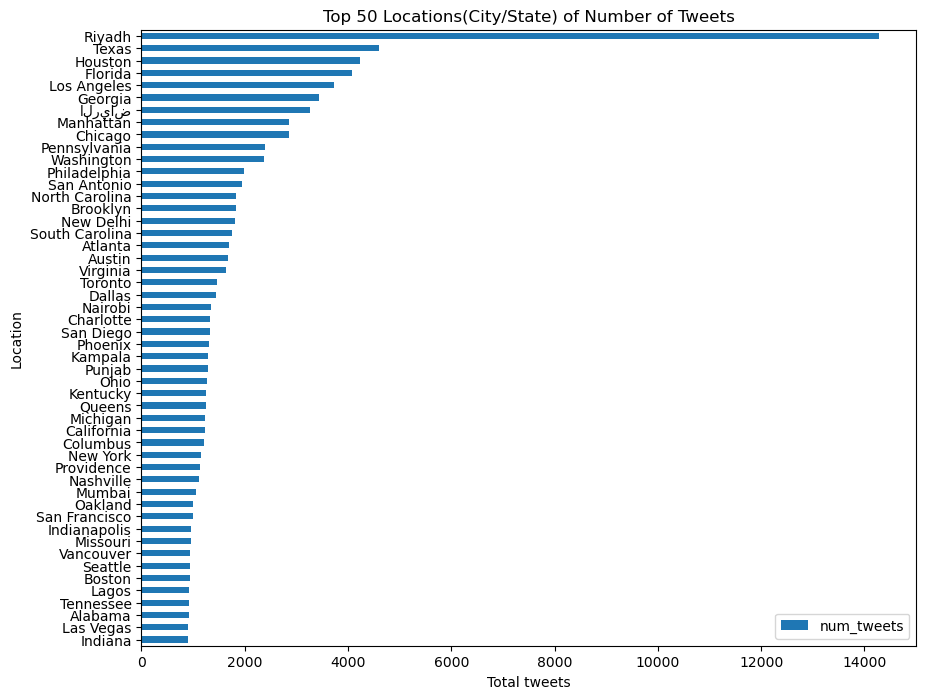

In [81]:
ax = top50_loc_f_df.plot(x ='loc',y='num_tweets', kind='barh', figsize = (10, 8))

ax.set_ylabel('Location')
ax.set_xlabel('Total tweets')
ax.set_title('Top 50 Locations(City/State) of Number of Tweets')
ax.invert_yaxis()

# show the plot
plt.show()

In [ ]:
# check why many tweets come from riyadh

In [43]:
riyadh = tweets.filter(tweets.place.full_name == 'Riyadh, Kingdom of Saudi Arabia')

In [51]:
spark.sql("set spark.sql.legacy.timeParserPolicy=LEGACY")
riyadh_timeline = riyadh.select('id', 'created_at')
riyadh_month = riyadh_timeline.withColumn("timestamp_unix", from_unixtime(unix_timestamp("created_at", "EEE MMM dd HH:mm:ss Z yyyy")))
riyadh_month = riyadh_month.withColumn("date", date_format("timestamp_unix", "yyyy-MM-dd"))
riyadh_month = riyadh_month.withColumn('month', month('date'))

In [56]:
r_d = riyadh_month.select('id', 'date')
r_tweets = r_d.groupby('date').agg(count('*'))

In [ ]:
r_tweets_day = r_tweets.orderBy('date', ascending = True)
r_tweets_day.show()

+----------+--------+
|      date|count(1)|
+----------+--------+
|2022-04-05|      13|
|2022-04-06|       8|
|2022-04-07|       7|
|2022-04-08|       5|
|2022-04-09|       7|
|2022-04-10|       5|
|2022-04-11|      16|
|2022-04-12|      36|
|2022-04-13|      13|
|2022-04-14|      11|
|2022-04-15|       7|
|2022-04-16|       7|
|2022-04-17|      16|
|2022-04-18|      23|
|2022-04-19|      40|
|2022-04-20|      40|
|2022-04-21|      41|
|2022-04-22|      27|
|2022-04-23|       9|
|2022-04-24|       8|
+----------+--------+
only showing top 20 rows



In [59]:
rt_df = r_tweets_day.toPandas()

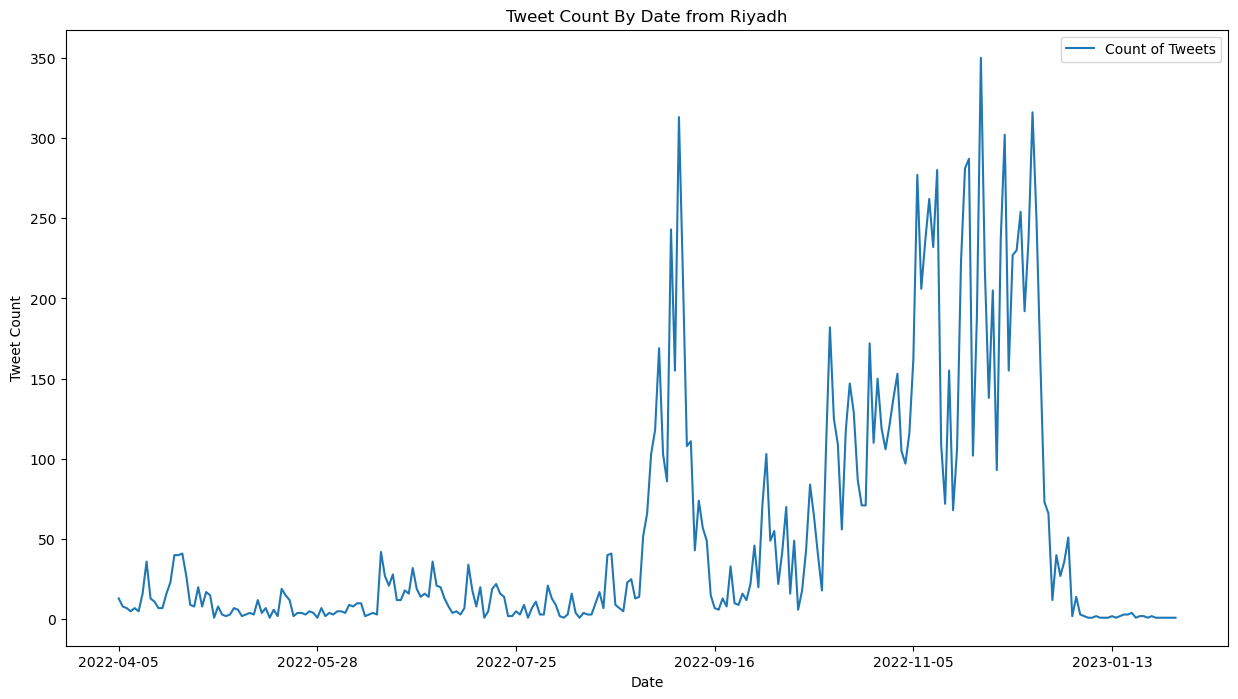

In [63]:
ax = rt_df.plot(kind="line", x='date', y="count(1)", figsize=(15, 8))
ax.set_ylabel("Tweet Count")
ax.set_xlabel('Date')
ax.set_title('Tweet Count By Date from Riyadh')

# Adding Legend and Renaming
ax.legend(['Count of Tweets'])

plt.show()

In [ ]:
# peak 1: Jul, Aug: Biden saudi visit
# peak 2: Dec: world cup

In [ ]:
# twitter user location

In [64]:
user_loc = tweets.select('id', tweets.user.location.alias('user_location'), tweets.user.id.alias('user_id'))

In [66]:
u_loc = user_loc.filter(col('user_location').isNotNull()) 

In [68]:
u_loc_count = u_loc.groupby('user_location').agg(count('user_id'))

In [71]:
lc_desc = u_loc_count.orderBy(col('count(user_id)').desc())

In [72]:
lc = lc_desc.withColumn("loction", split(lc_desc.user_location, ", ").getItem(0))

In [74]:
lc_f = lc.filter(col("user_location").like("%,%"))

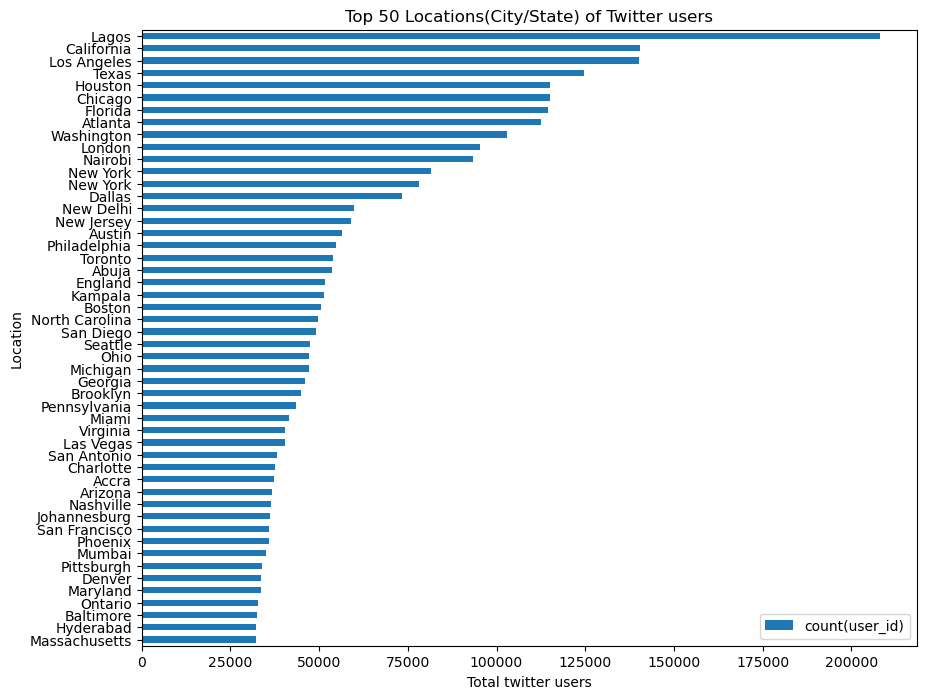

In [77]:
l_df = lc_f.limit(50).toPandas()
ax = l_df.plot(x ='loction',y='count(user_id)', kind='barh', figsize = (10, 8))

ax.set_ylabel('Location')
ax.set_xlabel('Total twitter users')
ax.set_title('Top 50 Locations(City/State) of Twitter users')
ax.invert_yaxis()

# show the plot
plt.show()

In [ ]:
# focus peaks in trend: may

In [9]:
spark.sql("set spark.sql.legacy.timeParserPolicy=LEGACY")
timeline = tweets.select('id', 'created_at', tweets.place.full_name.alias('tweet_location'))
timeline = timeline.withColumn("timestamp_unix", from_unixtime(unix_timestamp("created_at", "EEE MMM dd HH:mm:ss Z yyyy")))
timeline = timeline.withColumn("date", date_format("timestamp_unix", "yyyy-MM-dd"))
timeline = timeline.withColumn('month', month('date'))

In [11]:
timeline_loc = timeline.filter(col('tweet_location').isNotNull())

In [13]:
timeline_loc_may = timeline_loc.filter(col('month') == 5).select('id', 'tweet_location', 'date')

In [15]:
timeline_l_may = timeline_loc_may.withColumn('loc', split(timeline_loc_may.tweet_location, ", ").getItem(0))

In [20]:
may = timeline_l_may.groupby('loc').agg(count('id').alias('num_tweets')).orderBy(col('num_tweets').desc()).limit(50)

In [ ]:
may.show()

+--------------+----------+
|           loc|num_tweets|
+--------------+----------+
| United States|      4041|
|       Houston|       443|
|       Georgia|       410|
|   Los Angeles|       370|
|       Florida|       354|
|         Texas|       339|
|     Manhattan|       303|
|       Chicago|       278|
|    Washington|       241|
|  Philadelphia|       209|
|  Pennsylvania|       199|
|      Brooklyn|       192|
|North Carolina|       187|
|   San Antonio|       173|
|      Virginia|       171|
|       Atlanta|       170|
|        Austin|       168|
|South Carolina|       154|
|     New Delhi|       153|
|        Riyadh|       147|
+--------------+----------+
only showing top 20 rows



#### Topics

In [ ]:
# “Florida math book ban”

In [8]:
dt = tweets.select([tweets.created_at,
                    tweets.id_str.alias('tweet_id'),
                    tweets.user['id'].alias('user_id'), 
                    tweets.user['screen_name'].alias('user_name'),
                    tweets.user['verified'].alias('verified'),
                    tweets.user['followers_count'].alias('followers_count'),
                    tweets.user['description'].alias('user_description'),
                    tweets.user['location'].alias('user_location'),
                    tweets.text,
                    tweets.retweeted_status.retweet_count.alias('rt_count'),
                    tweets.retweeted_status.favorite_count.alias('rt_fav'),
                    tweets.retweeted_status.quote_count.alias('rt_quo'),
                    tweets.retweeted_status.retweeted.alias('retweet'),
                    tweets.retweeted_status.user['name'].alias('rt_user_name')])


In [ ]:
# filter texts to find those that contain “Florida math book ban”

In [15]:
fl_key = ['Florida', 'math', 'book', 'ban']
#filter out rows that do not contain words in keywords
dt = dt.withColumn('lower', lower(col('text')))
fl_dt = dt.filter(col('lower').rlike('|'.join(fl_key)))

In [16]:
fl_dt.count()

1620798

In [27]:
fl_dt_loc = fl_dt.filter(col('user_location').isNotNull())

In [28]:
spark.sql("set spark.sql.legacy.timeParserPolicy=LEGACY")
fl_may = fl_dt_loc.select('tweet_id', 'created_at', 'user_location')
fl_may = fl_may.withColumn("timestamp_unix", from_unixtime(unix_timestamp("created_at", "EEE MMM dd HH:mm:ss Z yyyy")))
fl_may = fl_may.withColumn("date", date_format("timestamp_unix", "yyyy-MM-dd"))
fl_may = fl_may.withColumn('month', month('date'))

In [29]:
fl_may

tweet_id,created_at,user_location,timestamp_unix,date,month
1604278645501181952,Sun Dec 18 00:53:...,"Capital city, LA",2022-12-18 00:53:29,2022-12-18,12
1604278670776041472,Sun Dec 18 00:53:...,United States,2022-12-18 00:53:35,2022-12-18,12
1604278780037660674,Sun Dec 18 00:54:...,"Missouri, USA",2022-12-18 00:54:01,2022-12-18,12
1604279313477632003,Sun Dec 18 00:56:...,"San Antonio, TX",2022-12-18 00:56:09,2022-12-18,12
1604279364690104322,Sun Dec 18 00:56:...,"Duluth,Minnesota USA",2022-12-18 00:56:21,2022-12-18,12
1604279474551259136,Sun Dec 18 00:56:...,"Stellenbosch, Sou...",2022-12-18 00:56:47,2022-12-18,12
1604279577362178048,Sun Dec 18 00:57:...,thy phrontistery,2022-12-18 00:57:11,2022-12-18,12
1604279665757409280,Sun Dec 18 00:57:...,western Washington,2022-12-18 00:57:33,2022-12-18,12
1604280491238096897,Sun Dec 18 01:00:...,Nigeria,2022-12-18 01:00:49,2022-12-18,12
1604280526268923906,Sun Dec 18 01:00:...,"Floyds Knobs, IN",2022-12-18 01:00:58,2022-12-18,12


In [30]:
fl_m_count = fl_may.groupby('date').agg(count('*').alias('daily_tweets'))

In [ ]:
fl_m_count

date,daily_tweets
2022-09-03,2933
2022-07-23,2107
2022-11-09,2549
2022-11-04,6096
2022-12-07,2906
2023-01-05,4164
2022-07-08,3069
2022-07-30,2892
2022-05-04,2538
2022-06-07,2431


In [32]:
fl_count = fl_m_count.orderBy('date', ascending = True)

In [33]:
fl_df = fl_count.toPandas()

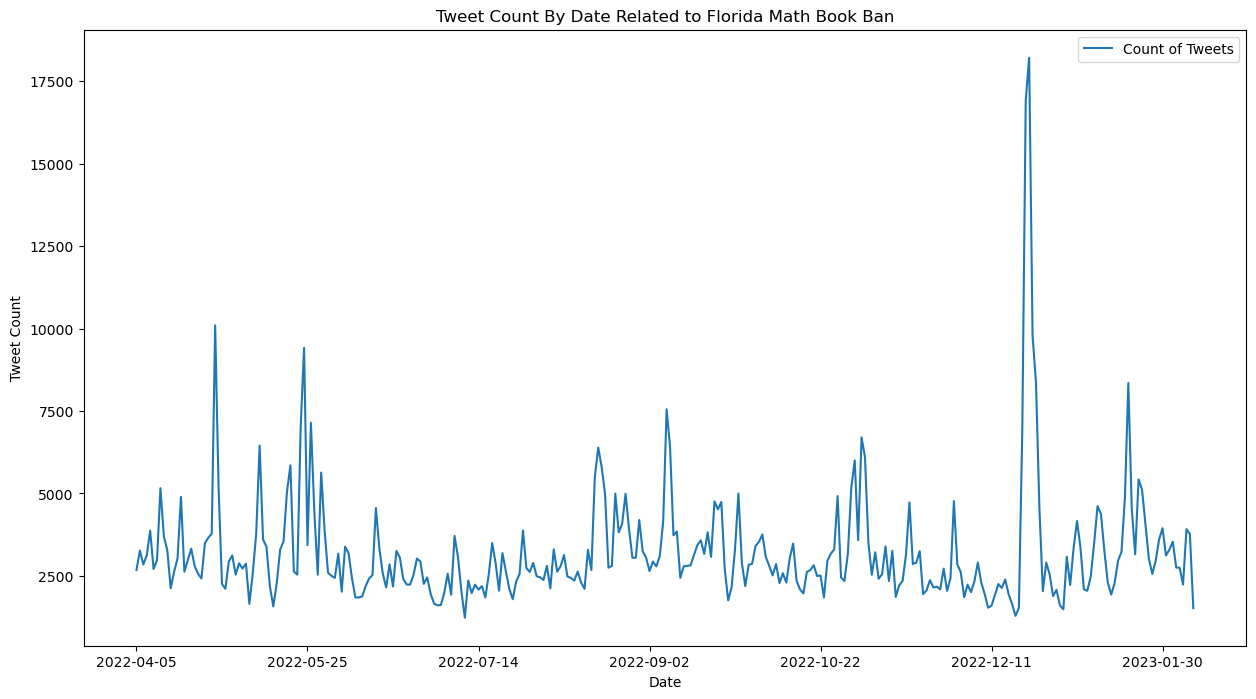

In [36]:
ax = fl_df.plot(kind="line", x='date', y="daily_tweets", figsize=(15, 8))
ax.set_ylabel("Tweet Count")
ax.set_xlabel('Date')
ax.set_title('Tweet Count By Date Related to Florida Math Book Ban')

# Adding Legend and Renaming
ax.legend(['Count of Tweets'])

plt.show()

In [48]:
fl_df['date'] = pd.to_datetime(fl_df['date'])
fl_df['M'] = fl_df['date'].dt.month

In [55]:
fl_df_4_5 = fl_df[(fl_df['M'] == 4) | (fl_df['M'] == 5)]

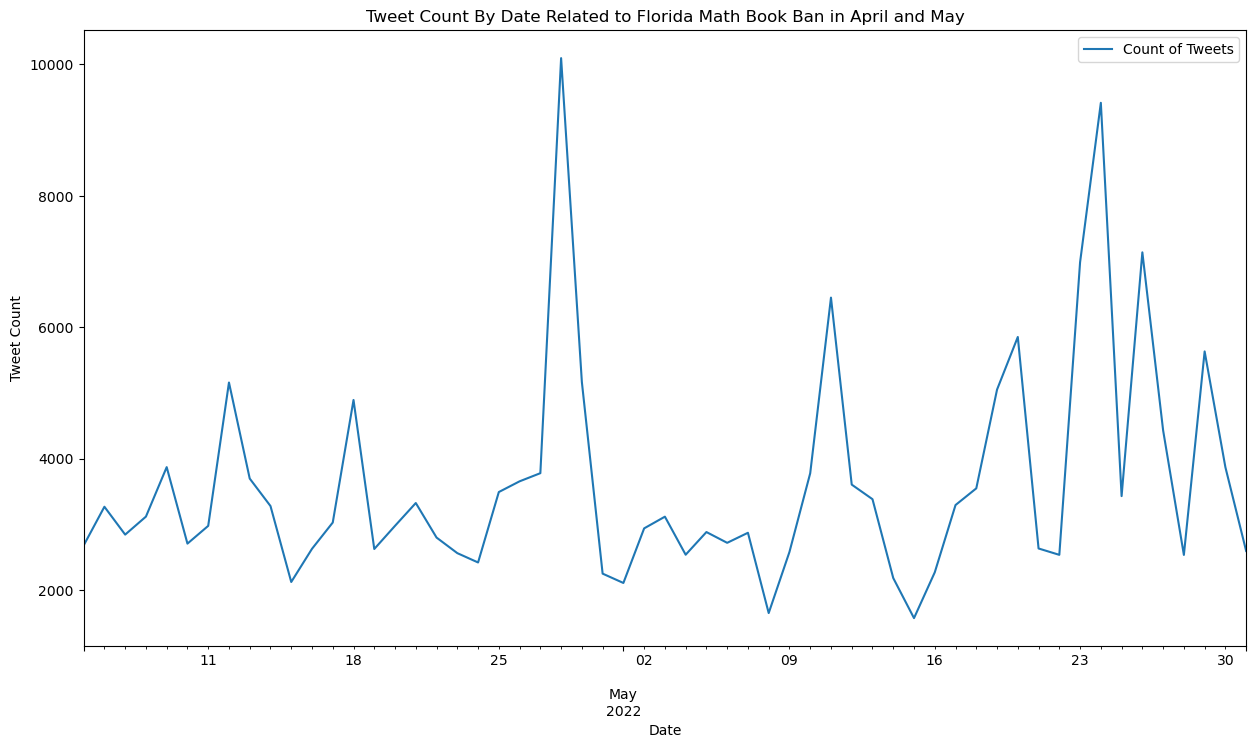

In [57]:
ax = fl_df_4_5.plot(kind="line", x='date', y="daily_tweets", figsize=(15, 8))
ax.set_ylabel("Tweet Count")
ax.set_xlabel('Date')
ax.set_title('Tweet Count By Date Related to Florida Math Book Ban in April and May')

# Adding Legend and Renaming
ax.legend(['Count of Tweets'])

plt.show()

In [58]:
fl_4_5 = fl_may.filter(col('month').isin([4, 5]))
fl_4_5 = fl_4_5.withColumn('loc', split(fl_4_5.user_location, ", ").getItem(0))
fl_4_5 = fl_4_5.filter(col("user_location").like("%,%"))
fl_count = fl_4_5.groupby('loc').agg(count('*').alias('num_tweets'))
fl_desc = fl_count.orderBy(col('num_tweets').desc()).limit(50)

In [59]:
fl_desc_df = fl_desc.toPandas()

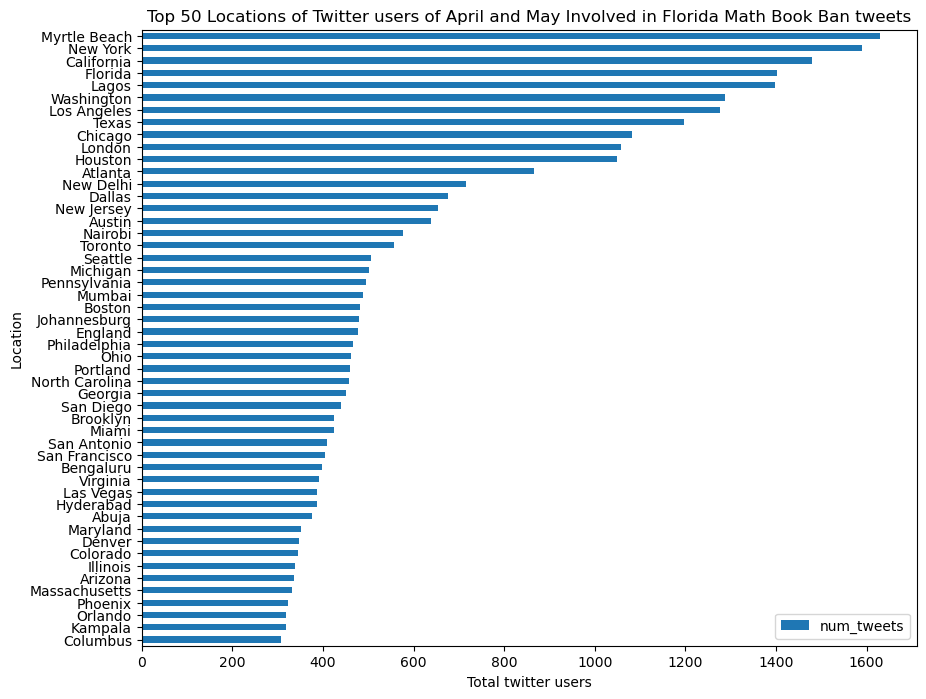

In [70]:
ax = fl_desc_df.plot(x ='loc',y='num_tweets', kind='barh', figsize = (10, 8))

ax.set_ylabel('Location')
ax.set_xlabel('Total twitter users')
ax.set_title('Top 50 Locations of Twitter users of April and May Involved in Florida Math Book Ban tweets')
ax.invert_yaxis()

# show the plot
plt.show()

In [ ]:
spark.sql("set spark.sql.legacy.timeParserPolicy=LEGACY")
tdt = dt.filter(col('user_location').isNotNull())
tdt = tdt.select('tweet_id', 'created_at', 'user_location')
tdt = tdt.withColumn("timestamp_unix", from_unixtime(unix_timestamp("created_at", "EEE MMM dd HH:mm:ss Z yyyy")))
tdt = tdt.withColumn("date", date_format("timestamp_unix", "yyyy-MM-dd"))
tdt = tdt.withColumn('month', month('date'))
tdt_4_5 = tdt.filter(col('month').isin([4, 5]))
tdt_4_5 = tdt_4_5.withColumn('loc', split(tdt_4_5.user_location, ", ").getItem(0))
tdt_4_5 = tdt_4_5.filter(col("user_location").like("%,%"))
tdt_count = tdt_4_5.groupby('loc').agg(count('*').alias('num_tweets'))
tdt_desc = tdt_count.orderBy(col('num_tweets').desc()).limit(50)
tdt_df = tdt_desc.toPandas()

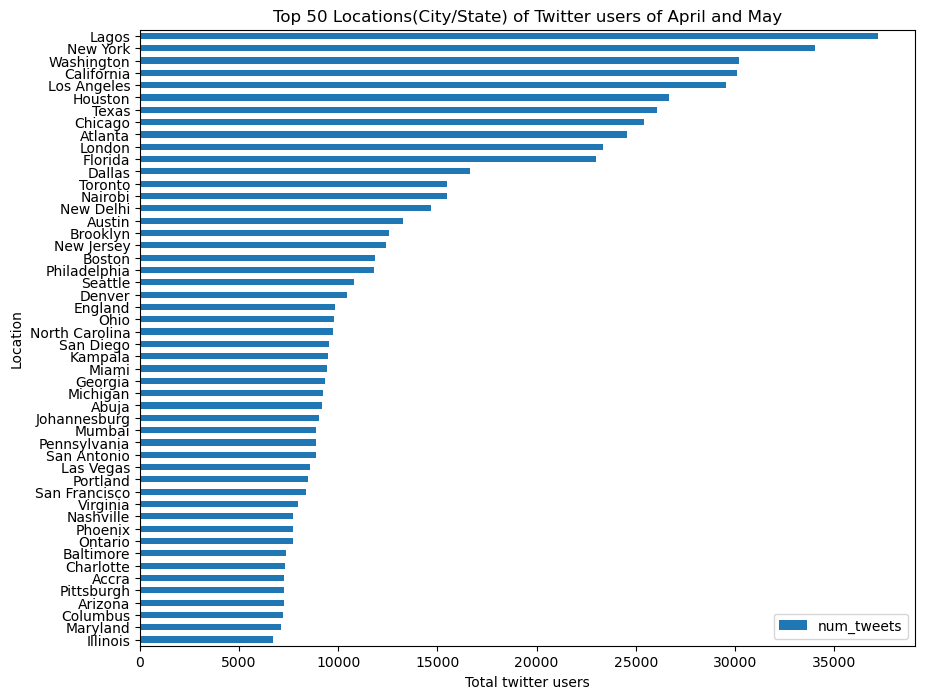

In [72]:
ax = tdt_df.plot(x ='loc',y='num_tweets', kind='barh', figsize = (10, 8))

ax.set_ylabel('Location')
ax.set_xlabel('Total twitter users')
ax.set_title('Top 50 Locations(City/State) of Twitter users of April and May')
ax.invert_yaxis()

# show the plot
plt.show()

In [ ]:
# chatgpt and education

In [9]:
gpt_key = ['chatgpt', 'gpt', 'ai']
#filter out rows that do not contain words in keywords
dt = dt.withColumn('lower', lower(col('text')))
gpt_dt = dt.filter(col('lower').rlike('|'.join(gpt_key)))

In [81]:
gpt_dt.count()

6399921

In [12]:
gpt_dt_loc = gpt_dt.filter(col('user_location').isNotNull())
spark.sql("set spark.sql.legacy.timeParserPolicy=LEGACY")
gpt_dt_loc = gpt_dt_loc.select('tweet_id', 'created_at', 'user_location')
gpt_dt_loc = gpt_dt_loc.withColumn("timestamp_unix", from_unixtime(unix_timestamp("created_at", "EEE MMM dd HH:mm:ss Z yyyy")))
gpt_dt_loc = gpt_dt_loc.withColumn("date", date_format("timestamp_unix", "yyyy-MM-dd"))
gpt_dt_loc = gpt_dt_loc.withColumn('month', month('date'))

In [13]:
gpt_ct = gpt_dt_loc.groupby('date').agg(count('*').alias('daily_tweets'))
gpt_ct_desc = gpt_ct.orderBy('date', ascending = True)

In [ ]:
gpt_ct_df = gpt_ct_desc.toPandas()

In [102]:
gpt_ct_df

,date,daily_tweets,M
0,2022-04-05,12760,4
1,2022-04-06,13760,4
2,2022-04-07,12778,4
3,2022-04-08,11672,4
4,2022-04-09,10318,4
...,...,...,...
305,2023-02-04,9619,2
306,2023-02-05,8535,2
307,2023-02-06,9963,2
308,2023-02-07,13035,2


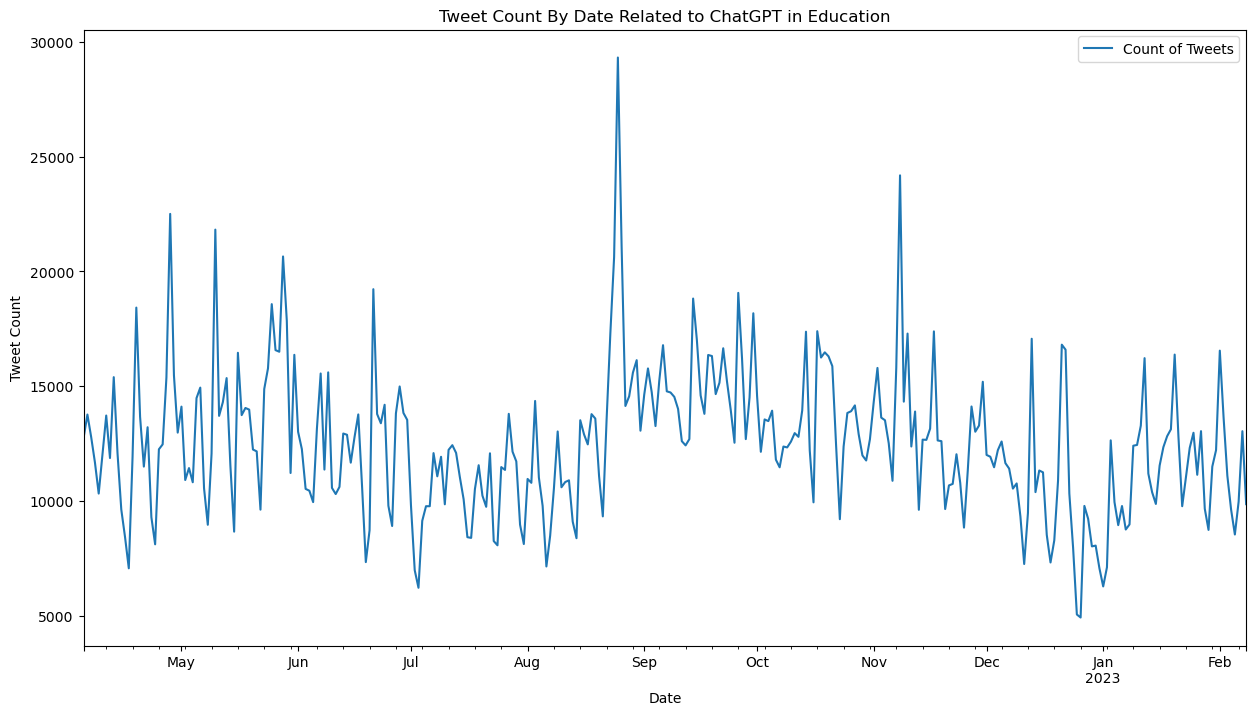

In [103]:
ax = gpt_ct_df.plot(kind="line", x='date', y="daily_tweets", figsize=(15, 8))
ax.set_ylabel("Tweet Count")
ax.set_xlabel('Date')
ax.set_title('Tweet Count By Date Related to ChatGPT in Education')

# Adding Legend and Renaming
ax.legend(['Count of Tweets'])

plt.show()

In [96]:
gpt_ct_df['date'] = pd.to_datetime(gpt_ct_df['date'])
gpt_ct_df['M'] = gpt_ct_df['date'].dt.month
gpt_df_11 = gpt_ct_df[(gpt_ct_df['M'] >= 11) | (gpt_ct_df['M'].isin([1,2]))]

In [97]:
gpt_df_11

,date,daily_tweets,M
210,2022-11-01,14299,11
211,2022-11-02,15791,11
212,2022-11-03,13626,11
213,2022-11-04,13512,11
214,2022-11-05,12504,11
...,...,...,...
305,2023-02-04,9619,2
306,2023-02-05,8535,2
307,2023-02-06,9963,2
308,2023-02-07,13035,2


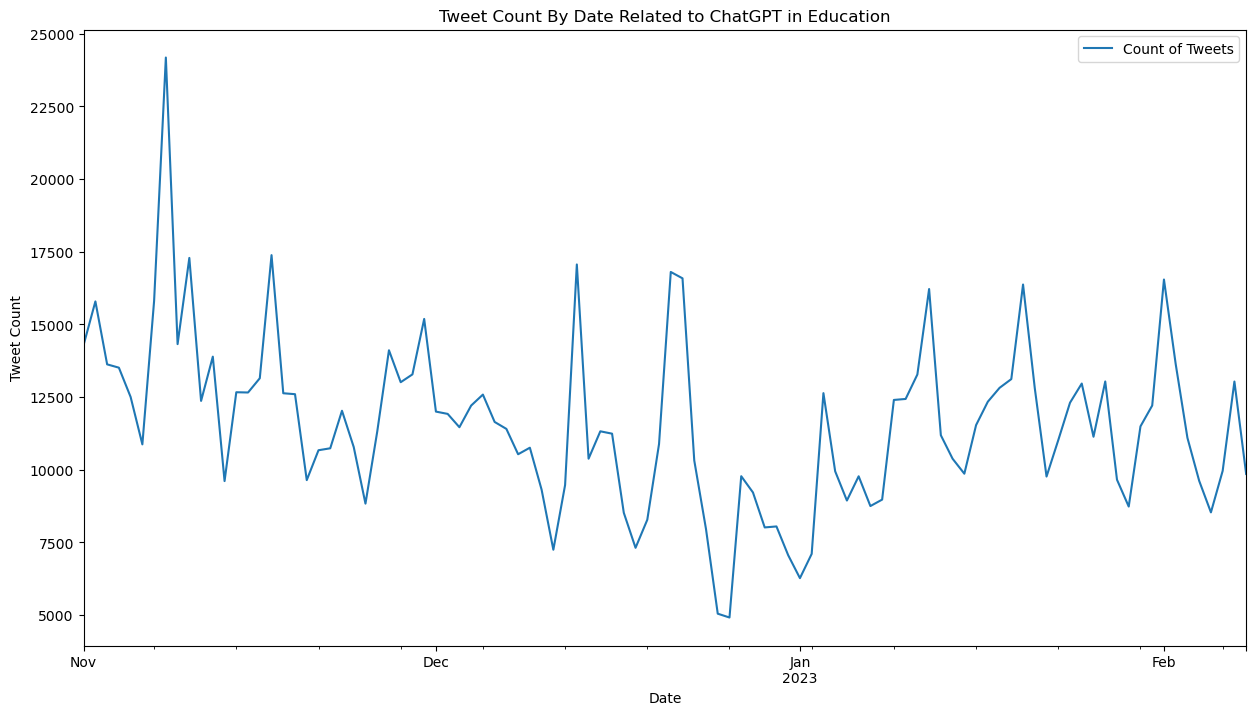

In [98]:
ax = gpt_df_11.plot(kind="line", x='date', y="daily_tweets", figsize=(15, 8))
ax.set_ylabel("Tweet Count")
ax.set_xlabel('Date')
ax.set_title('Tweet Count By Date Related to ChatGPT in Education')

# Adding Legend and Renaming
ax.legend(['Count of Tweets'])

plt.show()

In [14]:
gpt_loc = gpt_dt_loc.filter(col('month')==11)
gpt_loc = gpt_loc.withColumn('loc', split(gpt_loc.user_location, ", ").getItem(0))
gpt_loc = gpt_loc.filter(col("user_location").like("%,%"))
gpt_loc_count = gpt_loc.groupby('loc').agg(count('*').alias('num_tweets'))
gpt_loc_desc = gpt_loc_count.orderBy(col('num_tweets').desc()).limit(50)

In [15]:
gpt_loc_desc_df = gpt_loc_desc.toPandas()

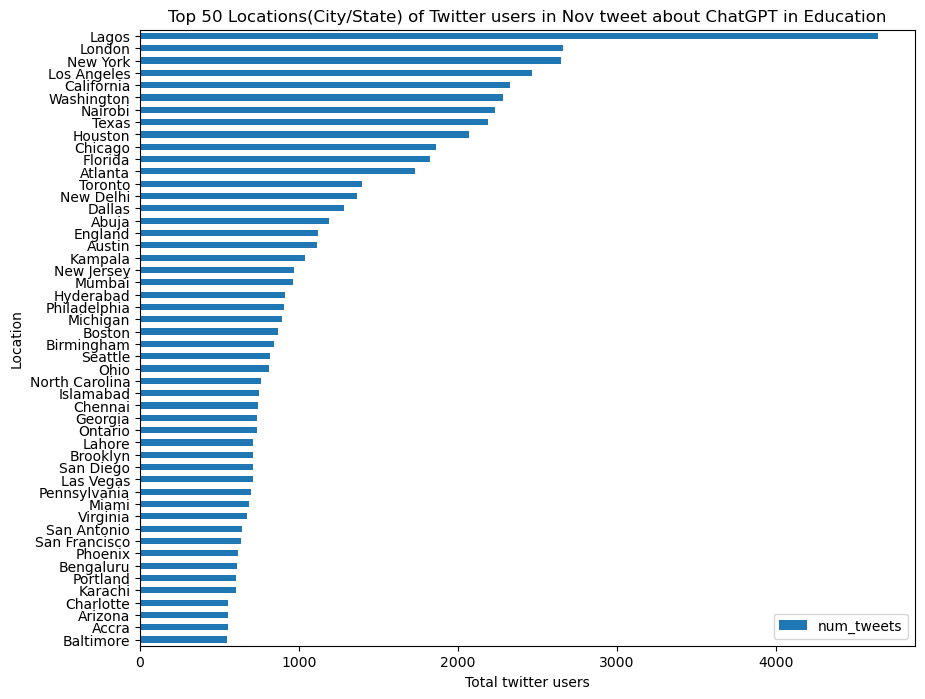

In [16]:
ax = gpt_loc_desc_df.plot(x ='loc',y='num_tweets', kind='barh', figsize = (10, 8))

ax.set_ylabel('Location')
ax.set_xlabel('Total twitter users')
ax.set_title('Top 50 Locations(City/State) of Twitter users in Nov tweet about ChatGPT in Education')
ax.invert_yaxis()

# show the plot
plt.show()

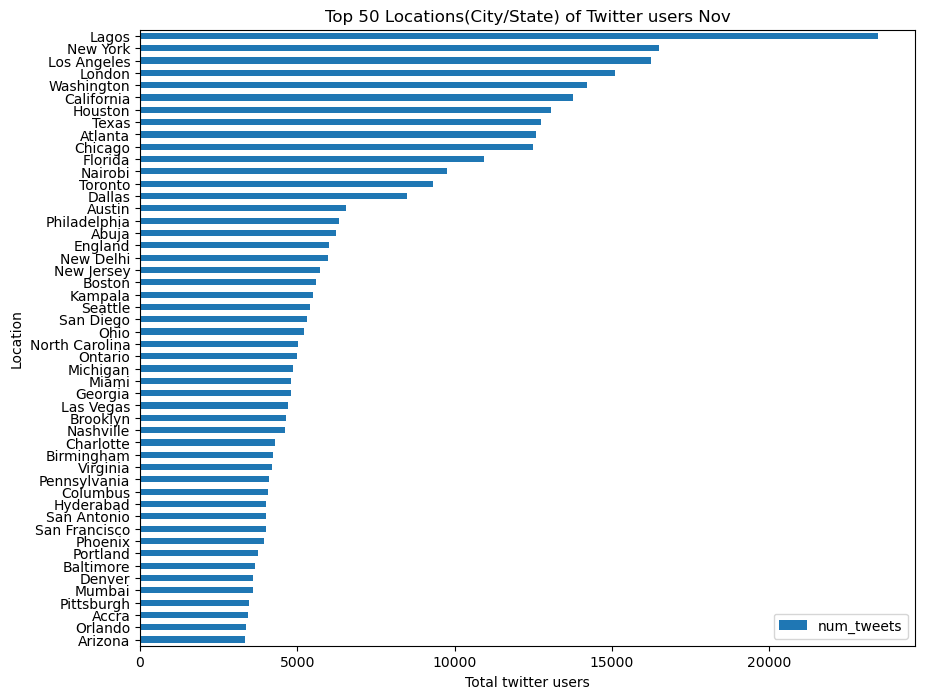

In [11]:
spark.sql("set spark.sql.legacy.timeParserPolicy=LEGACY")
tdt = dt.filter(col('user_location').isNotNull())
tdt = tdt.select('tweet_id', 'created_at', 'user_location')
tdt = tdt.withColumn("timestamp_unix", from_unixtime(unix_timestamp("created_at", "EEE MMM dd HH:mm:ss Z yyyy")))
tdt = tdt.withColumn("date", date_format("timestamp_unix", "yyyy-MM-dd"))
tdt = tdt.withColumn('month', month('date'))

tdt_11 = tdt.filter(col('month')==11)
tdt_11 = tdt_11.withColumn('loc', split(tdt_11.user_location, ", ").getItem(0))
tdt_11 = tdt_11.filter(col("user_location").like("%,%"))
tdt_count_11 = tdt_11.groupby('loc').agg(count('*').alias('num_tweets'))
tdt_desc_11 = tdt_count_11.orderBy(col('num_tweets').desc()).limit(50)
tdt_df_11 = tdt_desc_11.toPandas()
ax = tdt_df_11.plot(x ='loc',y='num_tweets', kind='barh', figsize = (10, 8))

ax.set_ylabel('Location')
ax.set_xlabel('Total twitter users')
ax.set_title('Top 50 Locations(City/State) of Twitter users Nov')
ax.invert_yaxis()

# show the plot
plt.show()

In [ ]:
gpt_loc_desc.write.format("parquet").\
mode('overwrite').\
save('gs://chen26-bdp/gpt_loc_desc')

In [108]:
t = spark.read.parquet('gs://chen26-bdp/gpt_loc_desc')

In [109]:
t

loc,num_tweets
Lagos,10913
New York,8369
London,7162
Washington,6949
Los Angeles,6808
California,6516
Nairobi,6172
Houston,6007
Texas,5841
Florida,5727


In [81]:
%%time
tweets_loc.write.format("parquet").\
mode('overwrite').\
save('gs://chen26-bdp/location_tweets')

CPU times: user 1.01 s, sys: 335 ms, total: 1.35 s
Wall time: 7min 56s


In [1]:
tweets_loc = spark.read.parquet('gs://chen26-bdp/location_tweets')

In [13]:
tweet_l = location.groupby(col('tweet_location')).agg(count('id').alias('num_tweets'))

In [14]:
top50_l = tweet_l.orderBy(col('num_tweets').desc())